### INFO

- https://medium.com/swlh/automating-your-stock-portfolio-research-with-python-for-beginners-912dc02bf1c2


- https://www.investopedia.com/ask/answers/122414/what-are-most-common-periods-used-creating-moving-average-ma-lines.asp#:~:text=Crossovers%20of%20the%2050%2Dday,.)%20to%20select%20moving%20averages.
- https://towardsdatascience.com/predicting-short-term-stock-movements-with-quantitative-finance-and-machine-learning-in-python-e6e04e3e0337

- <font color=green size=3>**When long crosses over short, SELL**</font>
- <font color=red size=3>**When short crosses over long, BUY**</font>
- 50 day by 10 or 20 are considered signifcant


- https://medium.com/coinmonks/legacy-banking-consumes-twice-as-much-energy-as-bitcoin-5b439fe10240

The first retracement level at 23.6% is \\$15.67, the second retracement level at 38.6\% is \\$13.05, and the next retracement level at 61.8\% is \\$8.82. 

**How to use the Fibonacci retracement trading strategy?**

The retracement levels can be used in a situation where you wanted to buy a particular stock but you have not been able to because of a sharp run-up in the stock price. In such a situation, wait for the price to correct to Fibonacci retracement levels such as 23.6\%, 38.2\%, and 61.8\% and then buy the stock.The ratios 38.2\% and 61.8\% are the most important support levels.

This Fibonacci retracement trading strategy is more effective over a longer time interval and like any indicator, using the strategy with other technical indicators such as RSI, MACD, and candlestick patterns can improve the probability of success.

**Should be below $8.82 to buy again.**

In [16]:
# Raw Package
import numpy as np
import pandas as pd
import requests

#Data Source
import yfinance as yf

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sma
# import pmdarima as pmd

from sklearn.preprocessing import StandardScaler
import datetime as dt

import warnings
warnings.filterwarnings(action='ignore')
# pd.set_option('max_columns', 150)
# pd.set_option('max_rows', 150)

In [17]:
def getdata(stock):
 # Company Quote Group of Items
    company_quote = requests.get(f"https://financialmodelingprep.com/api/v3/quote/{stock}")
    company_quote = company_quote.json()
    share_price = float("{0:.2f}".format(company_quote[0]['price']))

In [18]:
stock = 'AAPL'

In [19]:
# Balance Sheet Group of Items    
BS = requests.get(f"https://financialmodelingprep.com/api/v3/financials/balance-sheet-statement/{stock}?period=quarter")
# BS = BS.json()

In [20]:
# BS.json()

In [155]:
def analysis(ticker, period, interval, stma=True, start_date=None, 
             sma=20, lma=50, figsize=(12,6), threads=False):
    '''works best on days and not time intervals between days
       sma = short moving average length
       lma = long moving average length
    '''
    item = yf.download(tickers=ticker, period=period, interval=interval, threads=threads)
    print(item.shape)
    if start_date is None:
        start_date = item.index[0]

    price_min = item.Close.min()
    price_max = item.Close.max()
    diff = price_max - price_min
    level1 = price_max - 0.236 * diff
    level2 = price_max - 0.382 * diff
    level3 = price_max - 0.618 * diff

    level_price = pd.DataFrame( columns = ['Level','Price'])
    level_price.loc["0.0"] = price_max
    level_price.loc["0.236"] = level1
    level_price.loc["0.382"] = level2
    level_price.loc["0.618"] = level3
    level_price.loc["1.0"] = price_min
    print(level_price)

    rolls = item.Close.rolling(sma).mean().to_frame()
    rolls.columns = ['r{}'.format(sma)]
    rolls['r{}'.format(lma)] = item.Close.rolling(lma).mean()
    rolls['sign'] = np.sign(rolls['r{}'.format(lma)]-rolls['r{}'.format(sma)])
    rolls['sign_s'] = rolls.sign.shift(1)
    rolls['intx'] = np.where(rolls.sign != rolls.sign_s, 1, 0)

    fig, ax=plt.subplots(1,1,figsize=(12,6))
    item.Close.loc[start_date:].plot(ax=ax, color='k')
    if stma == True:
        item.Close.rolling(sma).mean().loc[start_date:].plot(ax=ax, style=['r:'])
        item.Close.rolling(lma).mean().loc[start_date:].plot(ax=ax, style=['g:'])
        for idx in rolls[rolls.intx==1].loc[start_date:].index:
            ax.axvline(idx, color='k', alpha=0.5)
    ax.axhspan(level1, price_min, alpha=0.4, color='lightsalmon')
    ax.axhspan(level2, level1, alpha=0.5, color='palegoldenrod')
    ax.axhspan(level3, level2, alpha=0.5, color='palegreen')
    ax.axhspan(price_max, level3, alpha=0.5, color='powderblue')
#     ax.set_xticklabels(item.Close.index.values, {'fontsize':10, 'rotation':45})
    plt.title(ticker)
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.legend(['Close Price','Short Ovr Long - Buy','Long Ovr Short - Sell'], loc=2);   
    
    return item

def weighted_mean(x,w):
    return np.sum(w*x)/np.sum(w)


def rsi(x, n=14, low=30, high=70, ra='standard'):
    '''Calculates RSI'''
    delta = x['Close'].diff().dropna()
    dUp, dDown = delta.clip(lower=0), delta.clip(upper=0)

    if ra == 'standard':
        RolUp = dUp.rolling(n).mean() #pd.rolling_mean(dUp, n)
        RolDown = dDown.abs().rolling(n).mean() #pd.rolling_mean(dDown, n).abs()
    else:
        RolUp = dUp.ewm(span=n).mean()
        RolDown = dDown.abs().ewm(span=n).mean()

    RS = RolUp / RolDown
    rsi= 100.0 - (100.0 / (1.0 + RS))
    
    fig, ax=plt.subplots(1,1,figsize=(12,6))
    rsi.plot(ax=ax);
    ax.axhspan(low, 0, alpha=0.1, color='g')
    ax.axhspan(100, high, alpha=0.1, color='r')
    ax.axhline(50,color='k', alpha=0.2)
    ax.legend(['RSI','Overbought - Sell','Oversold - Buy']) #,''])
    ax.set_title("RSI  N={}  Roll={}".format(n,ra));
    
    return rsi

- https://medium.com/geekculture/the-fibonacci-rsi-an-interesting-combination-in-trading-a1c118b9a317
- https://medium.com/swlh/creating-a-variable-rsi-for-dynamic-trading-a-study-in-python-2af3ff8eaf0c

- https://medium.com/analytics-vidhya/exploring-stock-data-with-a-yahoo-finance-python-module-319c6b3815ae
- https://github.com/RyanElliott10
- https://algotrading101.com/learn/yahoo-finance-api-guide/

### Fibonacci Retracements in Python

- https://blog.quantinsti.com/fibonacci-retracement-trading-strategy-python/
- https://towardsdatascience.com/fibonacci-retracements-in-python-470eb33b6362

[*********************100%***********************]  1 of 1 completed
(365, 6)
           Level      Price
0.0    51.689999  51.689999
0.236  40.397399  40.397399
0.382  33.411299  33.411299
0.618  22.118699  22.118699
1.0     3.840000   3.840000


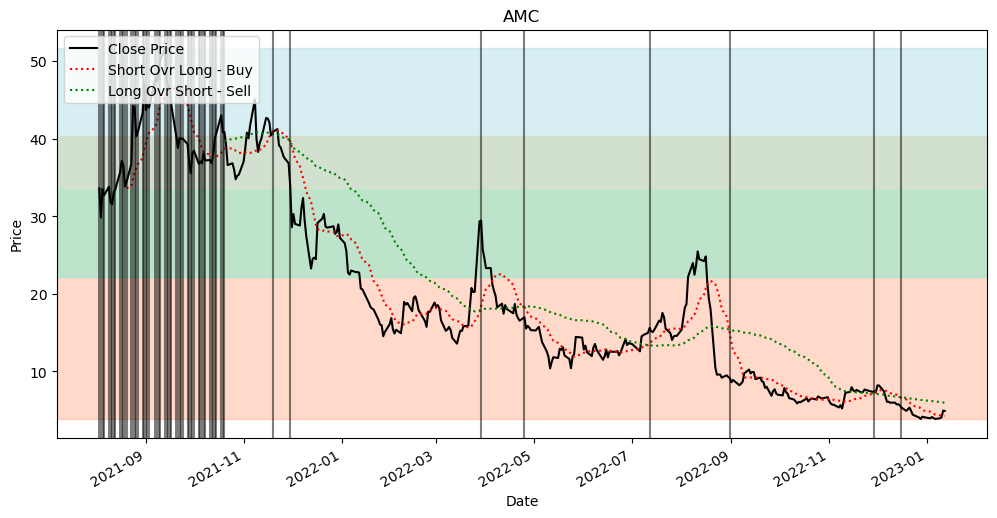

In [156]:
# amc = analysis('AMC', period='365d', interval='1d', start_date=dt.datetime(2021,1,1)) #pd.to_datetime('2021-01-01'))
amc = analysis('AMC', period='365d', interval='1d',
               sma=14, lma=56, start_date='2021-01-01')

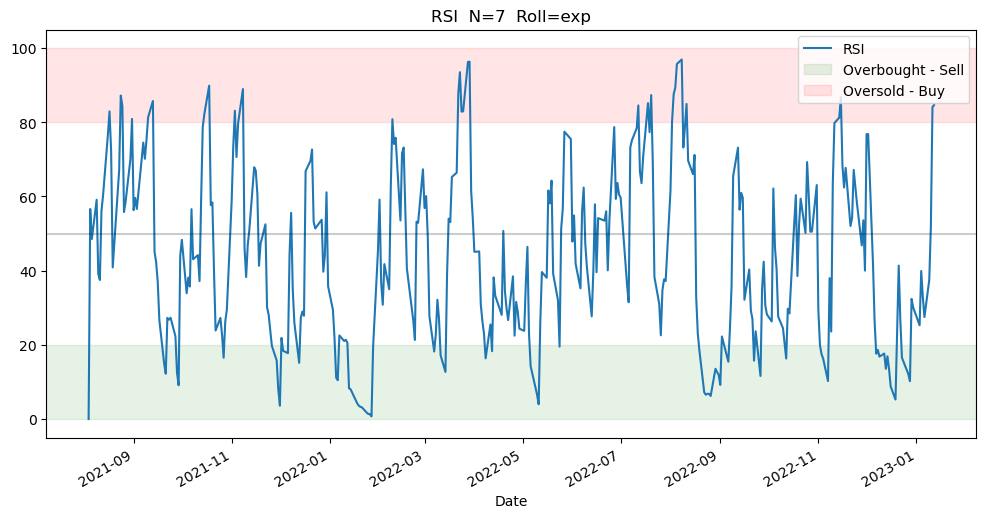

In [142]:
rsi(amc, n=7, low=20, high=80, ra='exp');

In [128]:
amc_ap = np.array([15.95,8,10.72]) 
amc_shr = np.array([5,5,10]) 

amc_ap = np.array([15.95,8,10.72,9.90])
amc_shr = np.array([5,5,10,10])

amc_ap = np.array([15.95,8,10.72,9.90,9.89]) # 4.13.2021
amc_shr = np.array([5,5,10,10,5])

wt_prc = weighted_mean(amc_ap, amc_shr)
print("Current Avg Cost = ${:.2f}".format(wt_prc))

des_prc = 169 #18 #13.4

net = des_prc*amc_shr.sum() - wt_prc*amc_shr.sum()

print("Desired Return at ${:.2f} = ${:.2f}".format(des_prc, net))

print("Current Return = ${:.2f}".format( amc.Close[-1]*amc_shr.sum() - wt_prc*amc_shr.sum()))

Current Avg Cost = $10.73
Desired Return at $169.00 = $5539.60
Current Return = $-202.04


In [129]:
def odds2prob(x):
    return x/(x+1)

In [130]:
print(odds2prob(13.5) * 100)
print(odds2prob(0.95) * 100)

93.10344827586206
48.717948717948715


### BITCOIN

[*********************100%***********************]  1 of 1 completed
(360, 6)
              Level         Price
0.0    47465.730469  47465.730469
0.236  39989.617145  39989.617145
0.382  35364.563986  35364.563986
0.618  27888.450662  27888.450662
1.0    15787.284180  15787.284180


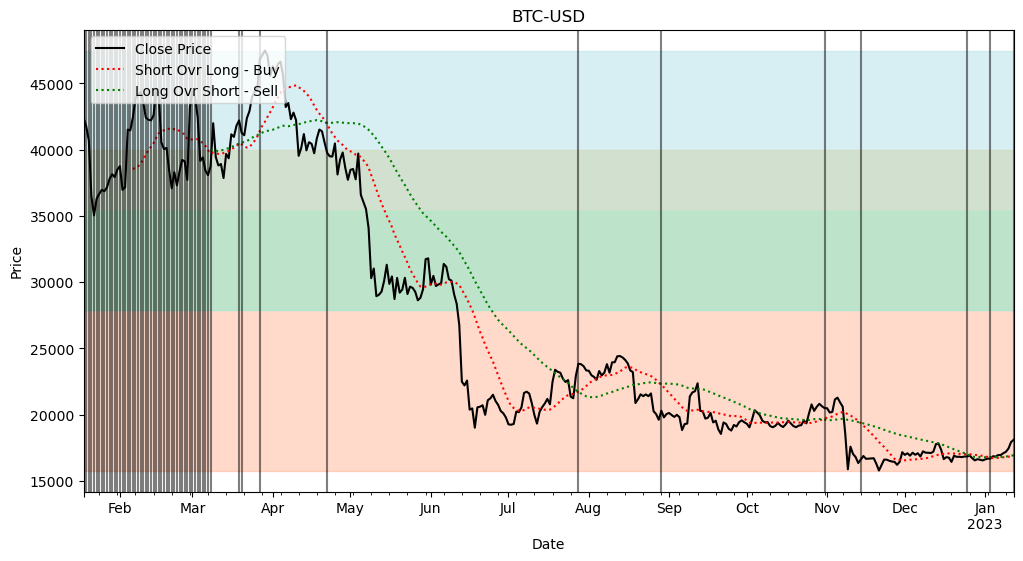

In [131]:
btc = analysis('BTC-USD','360d','1d',start_date='2021-01-01')

Looks bad for BTC and shows I probably should have sold...

In [132]:
my_btc = 0.01030852
btc_prc_paid = 100.01
btc_price = btc.Close[-1]
print("Capping at $39k gets me $300 profit.")
print(btc_price)
print("BTC RETURN = ${:,.2f}".format(btc_price * my_btc - 100.01))

Capping at $39k gets me $300 profit.
18104.611328125
BTC RETURN = $86.62


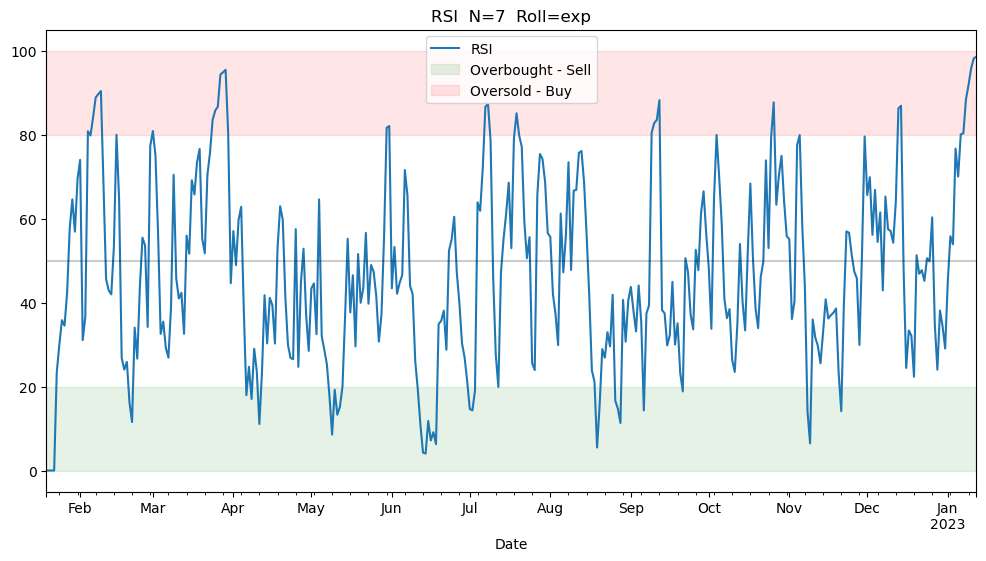

In [143]:
rsi(btc, n=7, low=20, high=80, ra='exp');

In [134]:
# btc2 = yf.download(tickers='BTC-USD', period='5000d', interval='1d')
# print(btc2.shape)
# fig, ax=plt.subplots(1,1,figsize=(12,5))
# btc2.Close.plot(ax=ax)
# ax.set_yscale('log');

### COINS

In [148]:
coins = ['DOGE-USD','ALGO-USD','ADA-USD', 'ETH-USD']

[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    0.172907  0.172907
0.236  0.144612  0.144612
0.382  0.127107  0.127107
0.618  0.098812  0.098812
1.0    0.053012  0.053012
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    1.319047  1.319047
0.236  1.046728  1.046728
0.382  0.878259  0.878259
0.618  0.605939  0.605939
1.0    0.165151  0.165151
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    1.465541  1.465541
0.236  1.177290  1.177290
0.382  0.998966  0.998966
0.618  0.710715  0.710715
1.0    0.244140  0.244140
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%***********************]  1 of 1 completed
(360, 6)
             Level        Price
0.0  

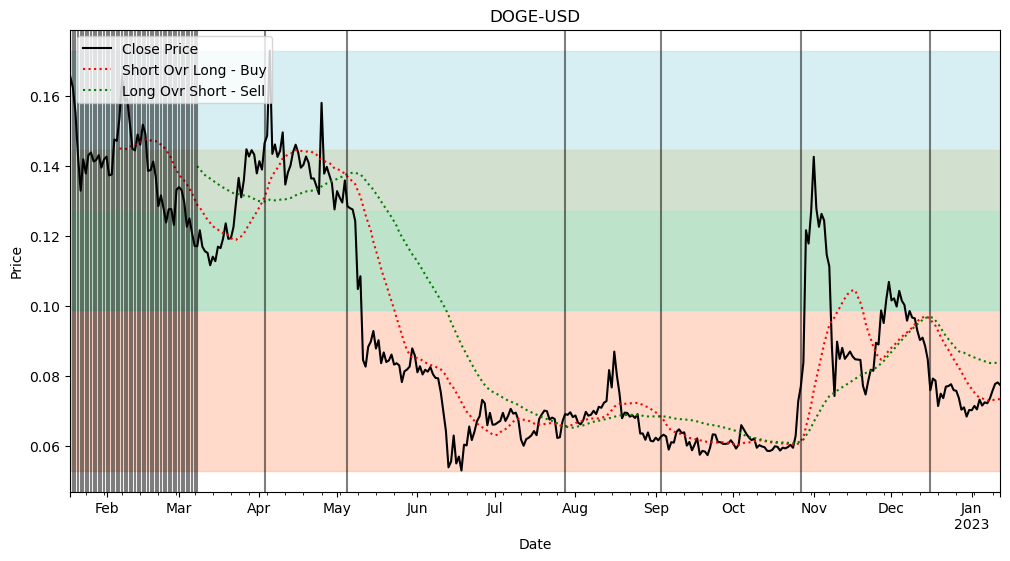

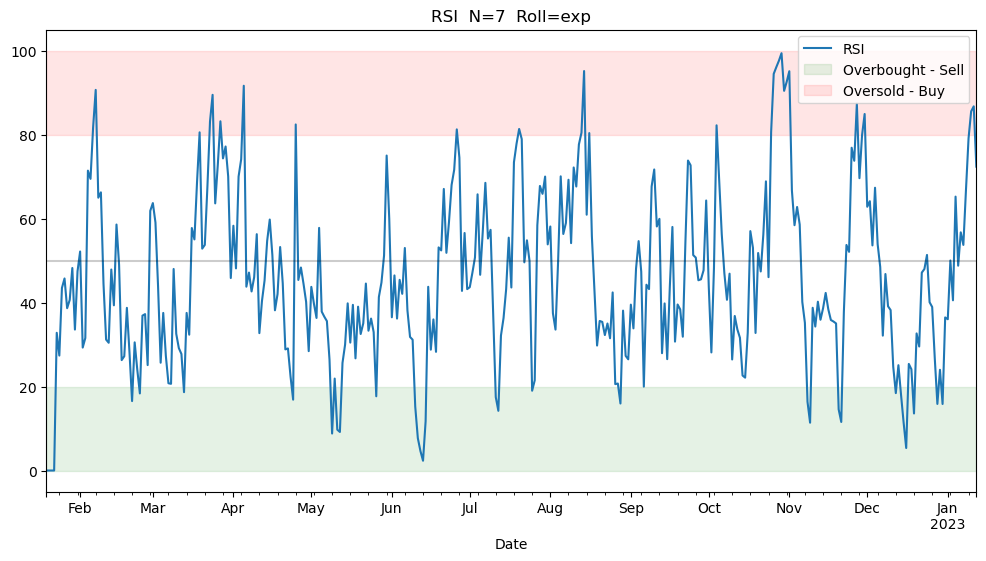

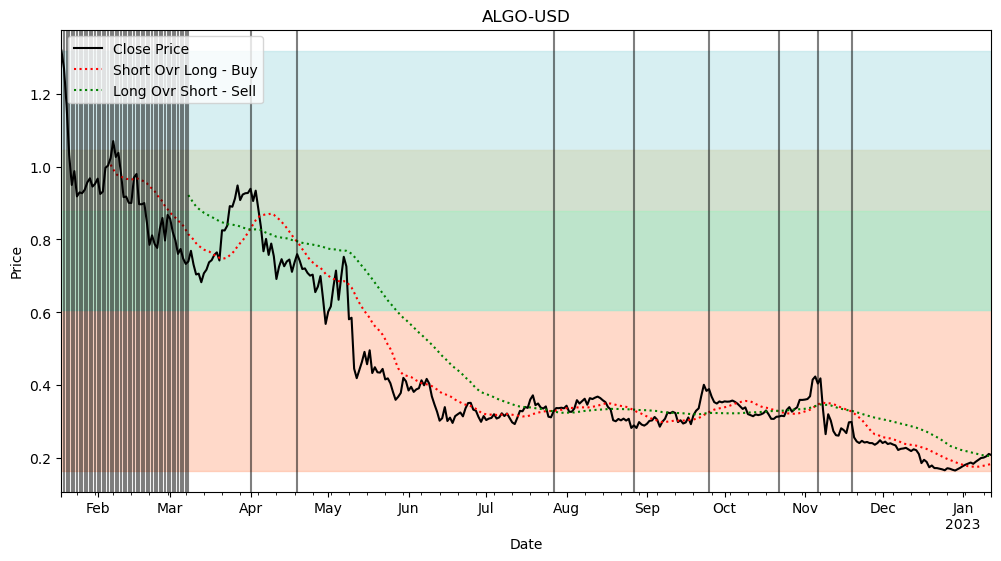

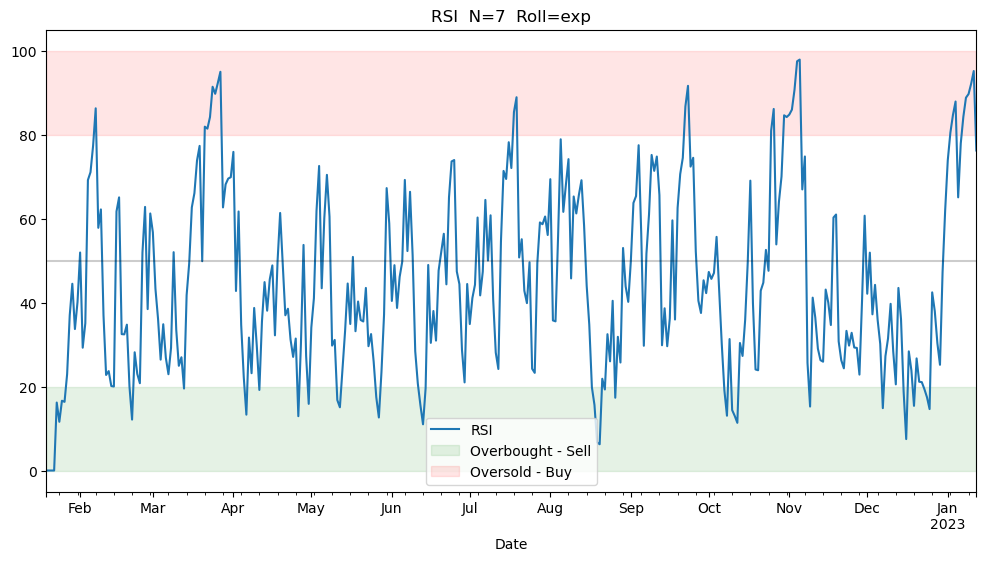

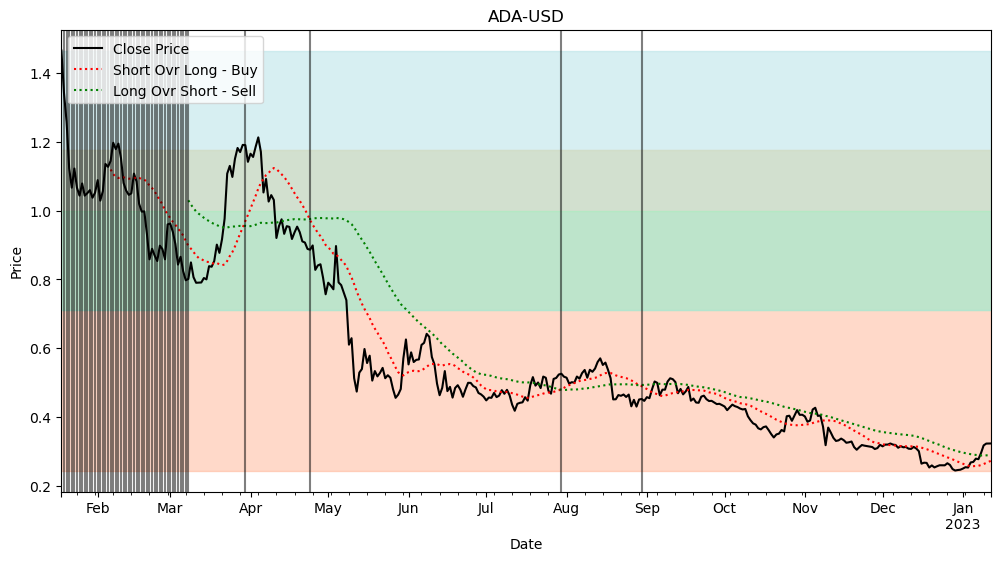

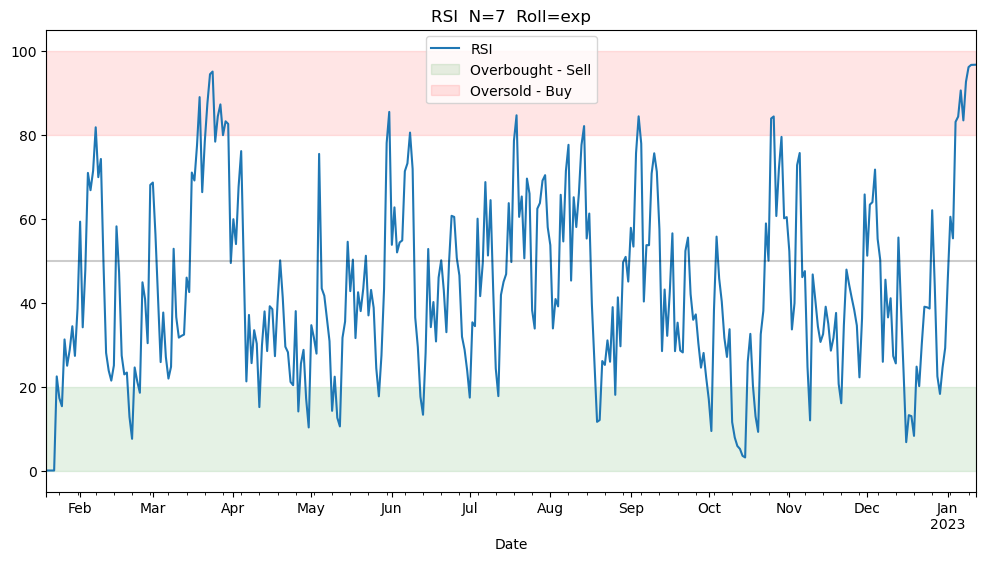

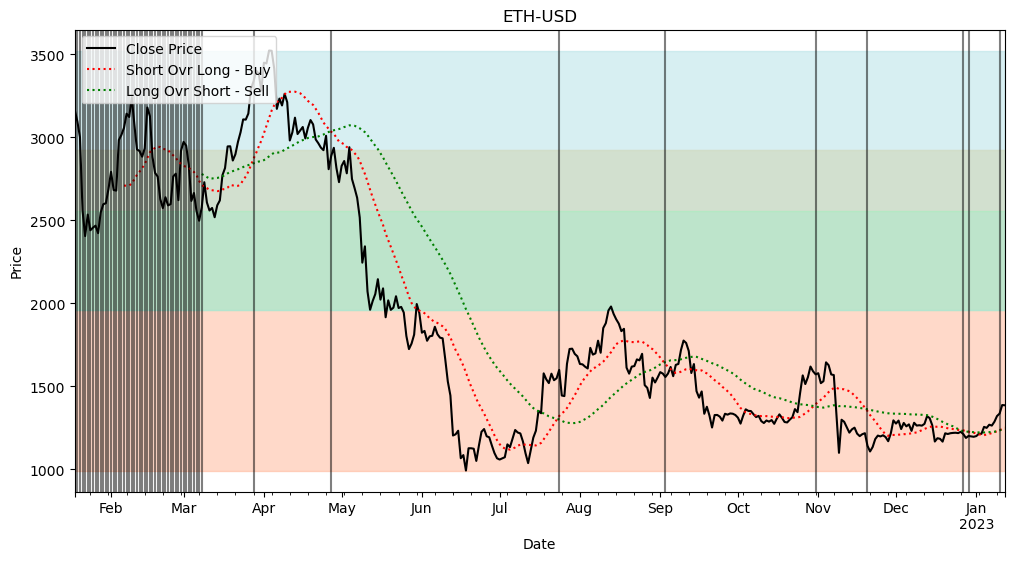

In [153]:
for c in coins:
    ctemp = analysis(c,'360d','1d',start_date='2021-01-01', sma=20)
    rsi(ctemp, n=7, low=20, high=80, ra='exp');
    print(" ="*30)

### STASH STOCKS

In [151]:
sstocks = ['GURU','IIPR','GLPI']

[*********************100%***********************]  1 of 1 completed
(360, 6)
           Level      Price
0.0    51.139999  51.139999
0.236  46.483719  46.483719
0.382  43.603140  43.603140
0.618  38.946860  38.946860
1.0    31.410000  31.410000
[*********************100%***********************]  1 of 1 completed
(360, 6)
            Level       Price
0.0    286.209991  286.209991
0.236  239.453673  239.453673
0.382  210.528153  210.528153
0.618  163.771834  163.771834
1.0     88.089996   88.089996
[*********************100%***********************]  1 of 1 completed
(360, 6)
         Level    Price
0.0    53.3200  53.3200
0.236  50.7712  50.7712
0.382  49.1944  49.1944
0.618  46.6456  46.6456
1.0    42.5200  42.5200


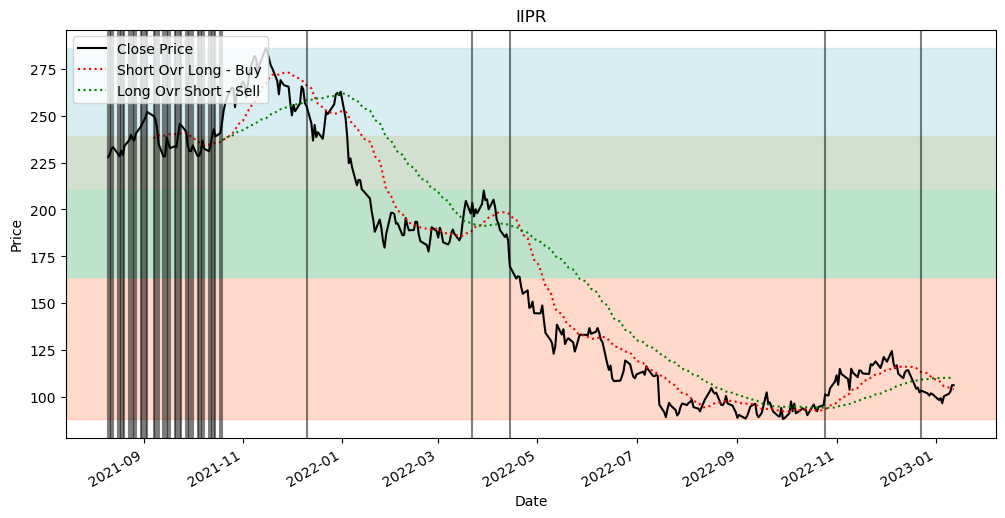

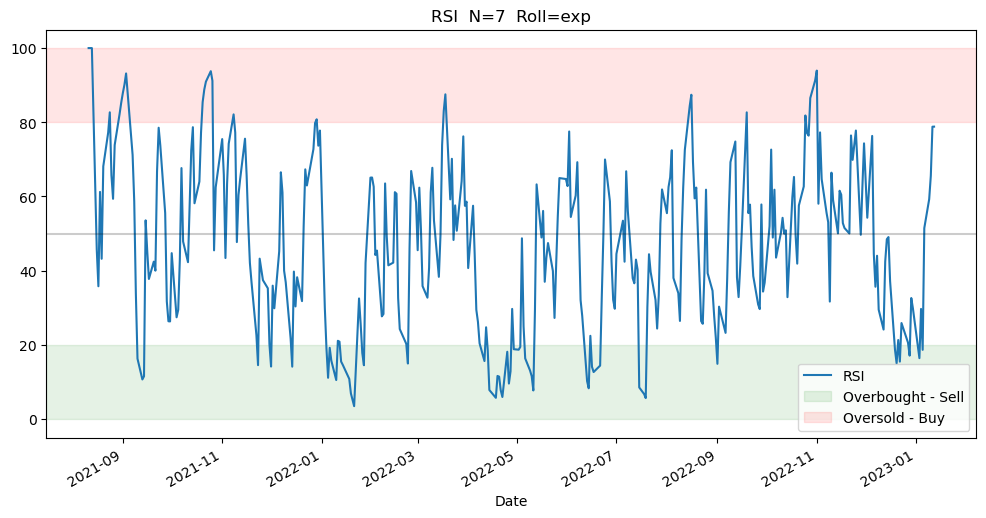

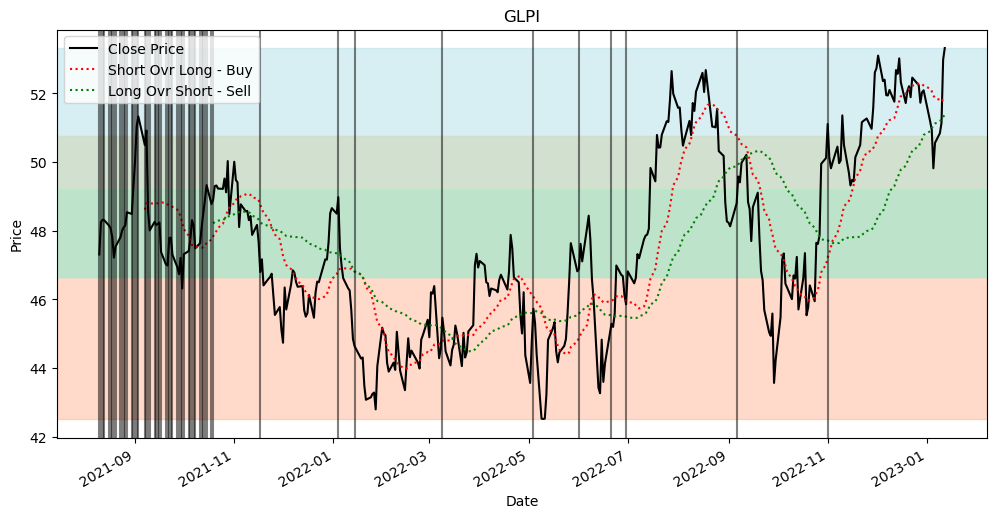

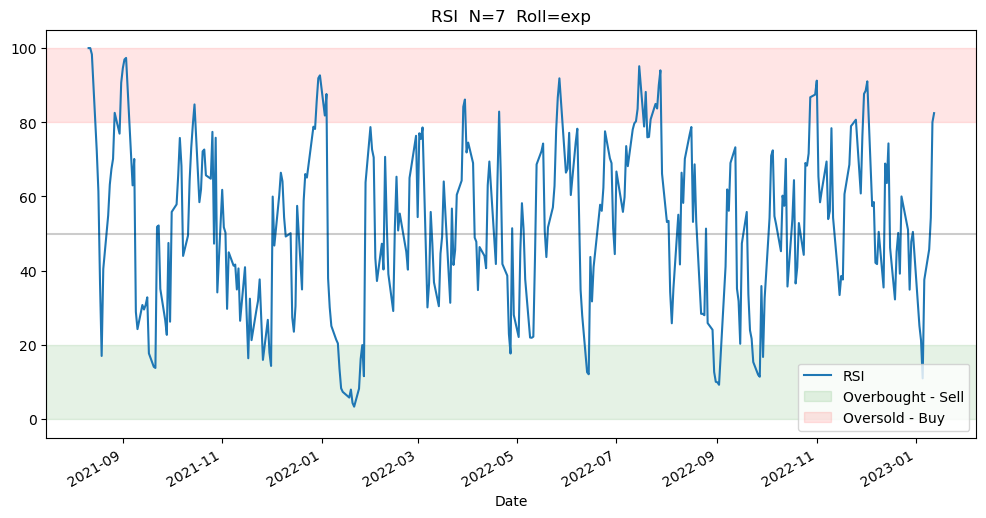

In [152]:
for s in sstocks:
    stemp = analysis(s,'360d','1d',start_date='2021-01-01', sma=10)
    rsi(stemp, n=7, low=20, high=80, ra='exp');

### WATCH LIST

Lots of loss here.

In [124]:
watch = ['AIEQ', 'ARKQ', 'BLOK', 'SPOT']

[*********************100%***********************]  1 of 1 completed
(360, 6)
           Level      Price
0.0    44.759998  44.759998
0.236  40.751303  40.751303
0.382  38.271347  38.271347
0.618  34.262651  34.262651
1.0    27.774000  27.774000
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%***********************]  1 of 1 completed
(360, 6)
           Level      Price
0.0    89.839996  89.839996
0.236  77.955037  77.955037
0.382  70.602478  70.602478
0.618  58.717518  58.717518
1.0    39.480000  39.480000
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%***********************]  1 of 1 completed
(360, 6)
          Level     Price
0.0    62.77000  62.77000
0.236  51.42548  51.42548
0.382  44.40726  44.40726
0.618  33.06274  33.06274
1.0    14.70000  14.70000
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = =
[*********************100%*****

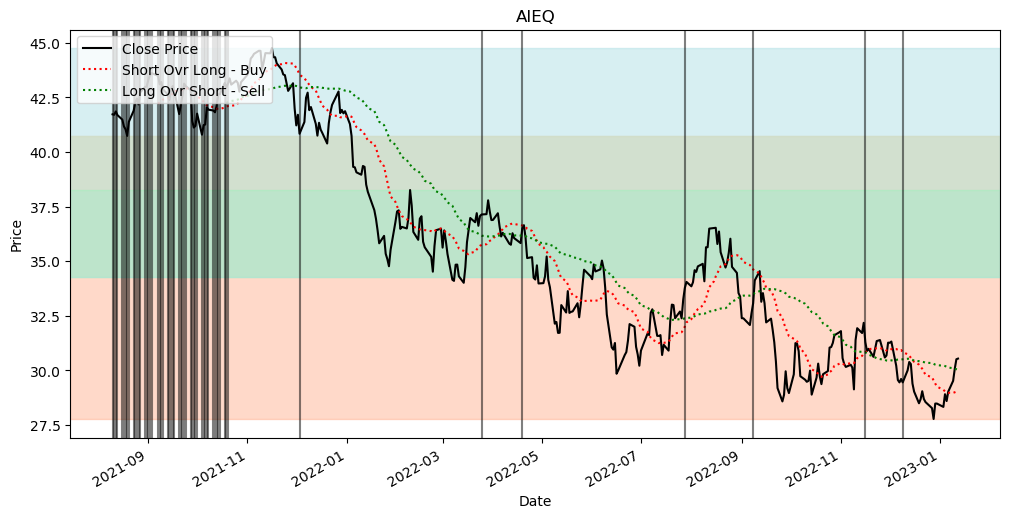

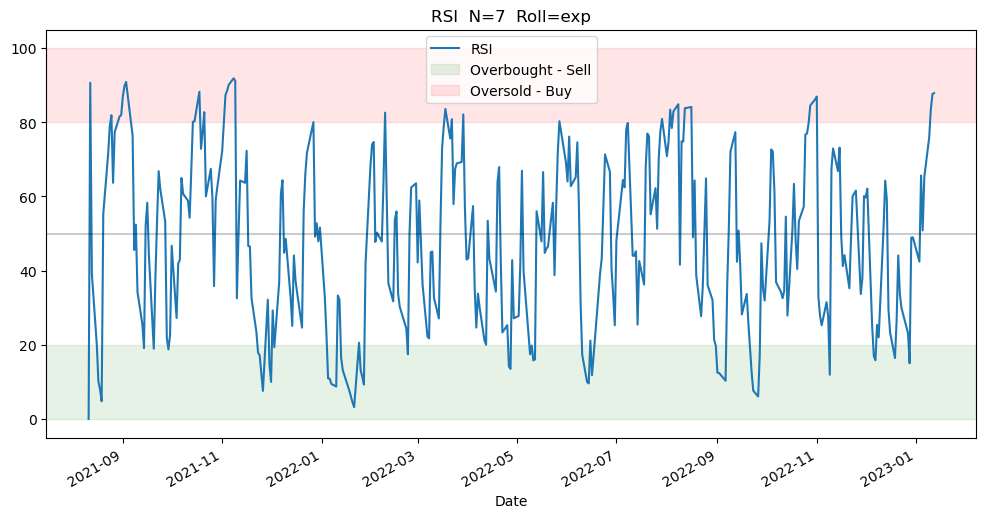

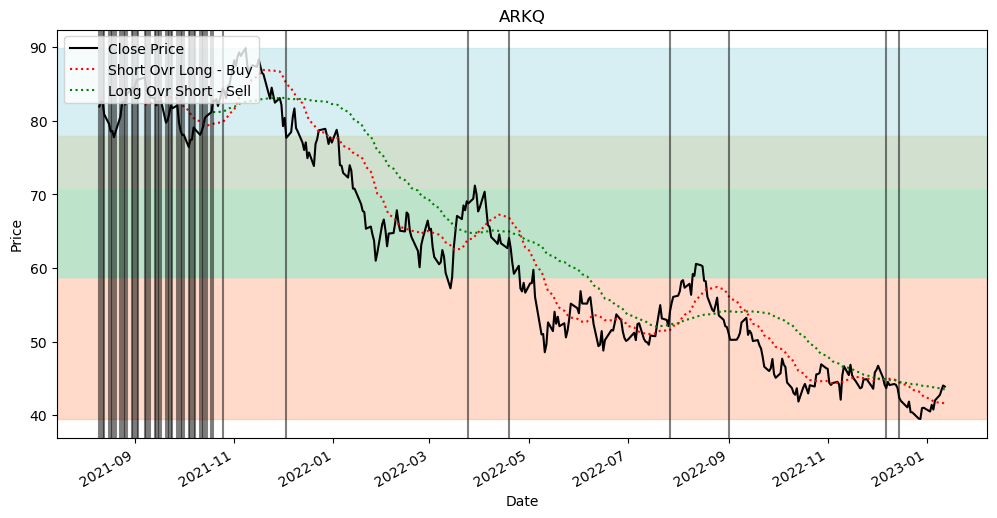

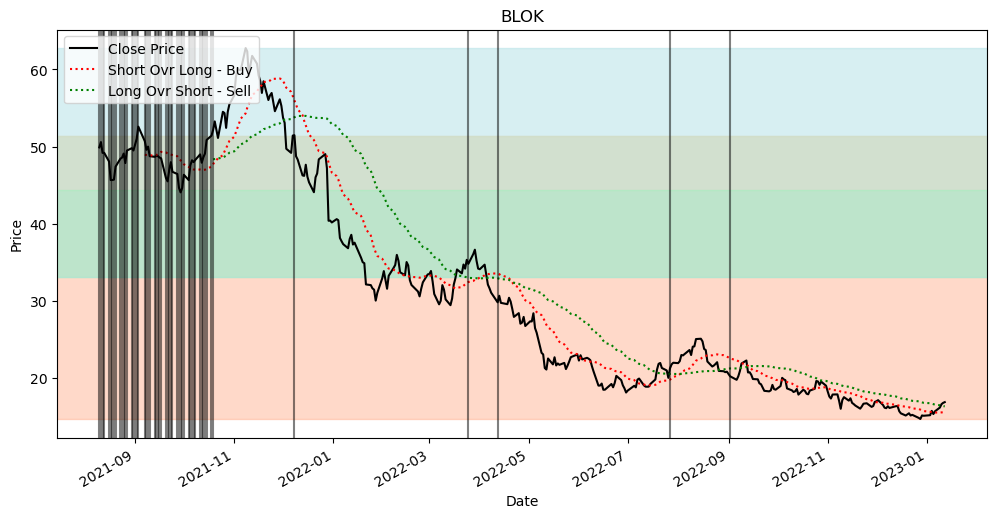

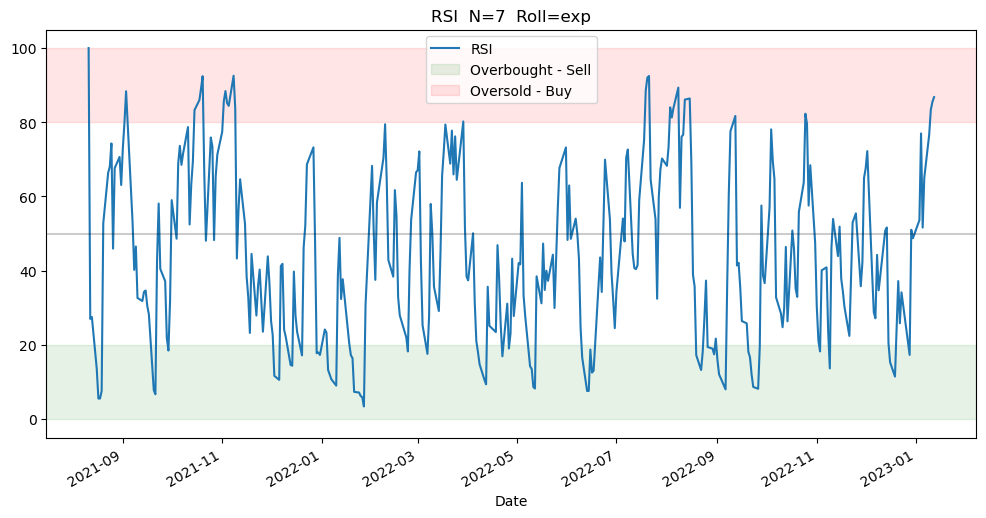

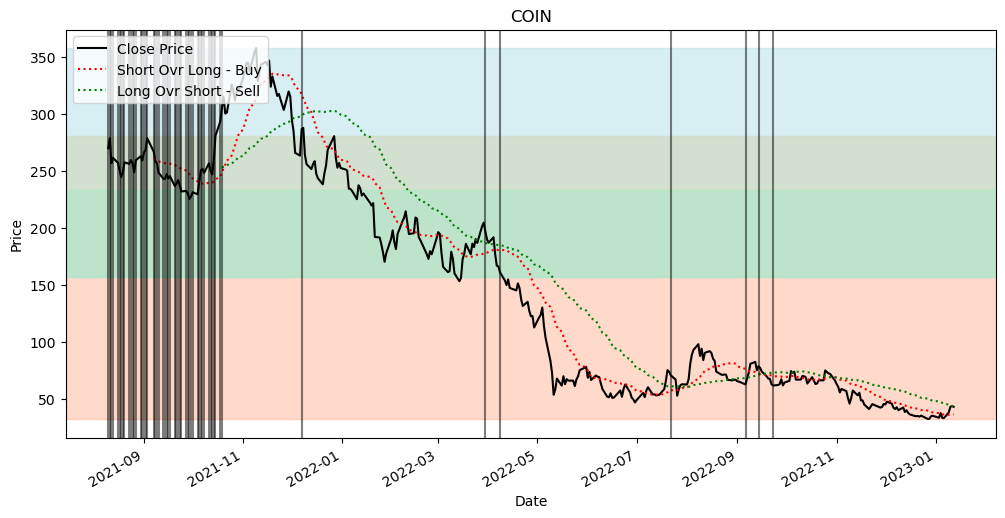

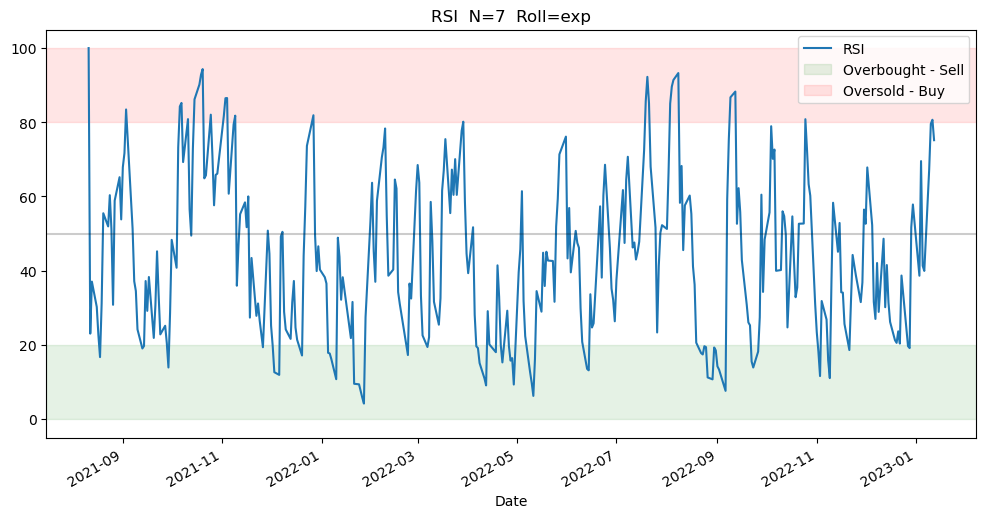

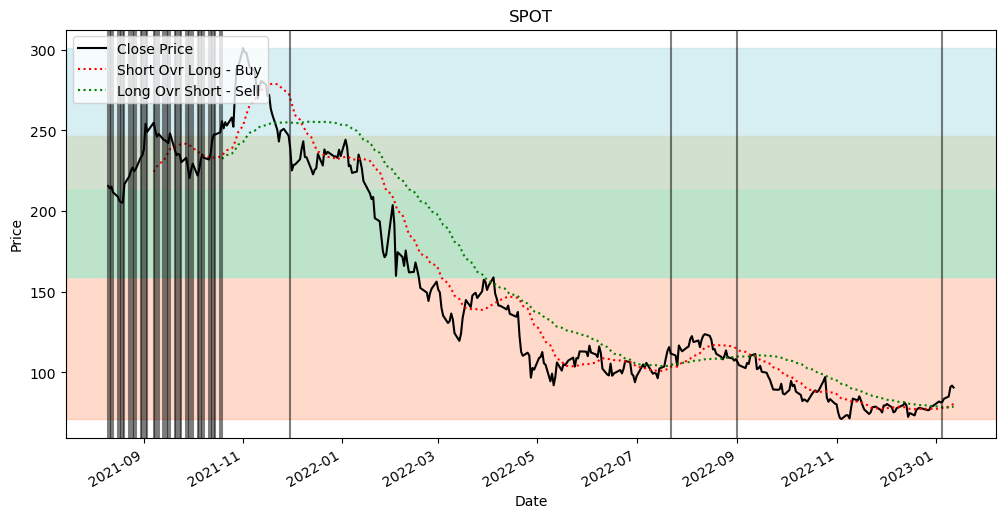

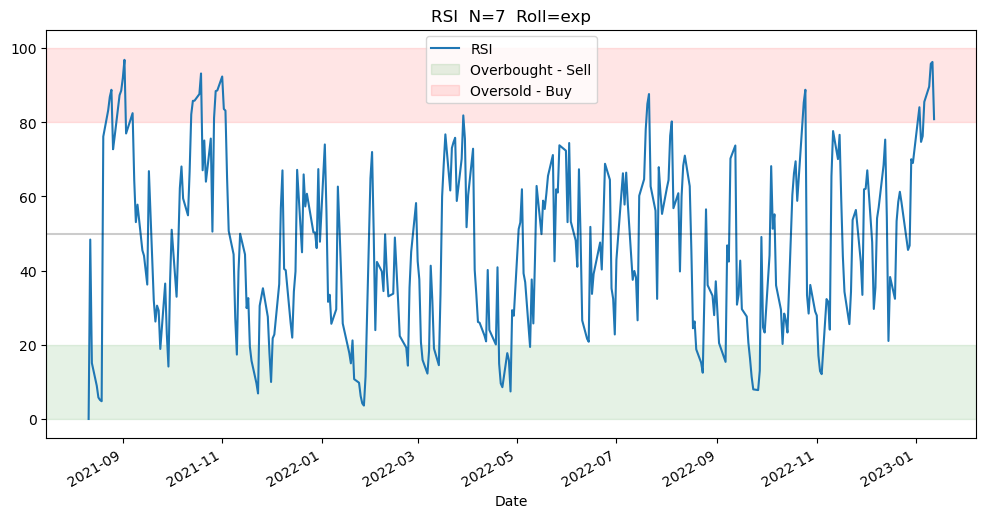

In [154]:
for w in watch:
    wtmp = analysis(w,'360d','1d',start_date='2021-01-01', sma=10)
    rsi(wtmp, n=7, low=20, high=80, ra='exp');
    print(" =" *40)